# XGB regression

In this notebook, we perform an XGB Regression.

In [367]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, median_absolute_error,r2_score, median_absolute_error
from sklearn.model_selection import LeaveOneOut, cross_val_score, GridSearchCV, train_test_split
import xgboost as xgb
from scripts import function
from imblearn.over_sampling import SMOTENC

In [368]:
merged_df = pd.read_csv("Clean_data/Merged_data.csv")


Flag where click rate is nan

In [369]:
merged_df['click_rate_isnan'] = merged_df['Click Rate'].isnull()

Select rows where Click rate is not nan

In [370]:
#merged_df = merged_df[~merged_df['click_rate_isnan']]

Remove outliers

In [371]:
outliers = np.log10(merged_df['Total Conversions']+1) > 5.0
merged_df = merged_df[~outliers]

Make transformations

In [372]:
merged_df['Clicks'],clicks_mean,clicks_var = function.make_all_transform(merged_df,'Clicks',
                                                                         log=True,normalize=True,
                                                                         scale=False)
merged_df['Impressions'],imp_mean,imp_var = function.make_all_transform(merged_df,'Impressions',
                                                                         log=True,normalize=True)
merged_df['Total_Conversions'],_,_=function.make_all_transform(merged_df,'Total Conversions',
                                                               log=True,normalize=True)
merged_df['Reach'],_,_ = function.make_all_transform(merged_df, 'Reach',log=True,normalize=True)

#merged_df['Click_Rate'],_,_ = function.make_all_transform(merged_df,'Click Rate',log=True,scale=False)

In [373]:
df=merged_df[['Reach','Total_Conversions',
              'Placement Pixel Size Bin','Site Bin']]
df=df.rename(columns={'Placement Pixel Size Bin':'Pb','Site Bin':'Sb'})

In [374]:
categorical_features = ['Sb','Pb']
df=df[['Reach','Total_Conversions'] + categorical_features]

#### One hot encode

In [375]:
df[categorical_features] = df[categorical_features].astype('category')
df = pd.get_dummies(df, drop_first=True)

#### Train test split

In [376]:
X=df.drop('Total_Conversions',axis=1)
y=df[['Total_Conversions']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [377]:
smote_cond = np.log10(merged_df['Total Conversions']+1) > 1.0
cat_variables = list(X_train.drop('Reach', axis=1).columns.values)
df_train = pd.concat([X_train, y_train], axis=1)
df_train = function.apply_smote(df_train,smote_cond,cat_vars=cat_variables)
X_train = df_train.drop('Total_Conversions', axis=1)
y_train = df_train[['Total_Conversions']].values

#### Interacting terms

In [378]:
#from sklearn.preprocessing import PolynomialFeatures
#interacter = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
#X_train_int = interacter.fit_transform(X_train)

In [379]:
#X_train_int = pd.DataFrame(columns=interacter.get_feature_names(X_train.columns), data=X_train_int)

In [380]:
#to_drop = [c for c in X_train_int.columns if 'Reach' not in c]
#X_train_int = X_train_int.drop(to_drop, axis=1)
#to_drop = [c for c in X_train_int.columns if 'Sb' not in c]
#X_train_int = X_train_int.drop(to_drop, axis=1)
#to_drop = [c for c in X_train_int.columns if 'Pb' not in c]
#X_train = X_train_int.drop(to_drop, axis=1)
#X_train.drop('Reach',axis=1,inplace=True)

In [381]:
##do the same for test data
#X_test_int = interacter.fit_transform(X_test)
#X_test_int = pd.DataFrame(columns=interacter.get_feature_names(X_test.columns), data=X_test_int)
#to_drop = [c for c in X_test_int.columns if 'Reach' not in c]
#X_test_int = X_test_int.drop(to_drop, axis=1)
#to_drop = [c for c in X_test_int.columns if 'Sb' not in c]
#X_test_int = X_test_int.drop(to_drop, axis=1)
#to_drop = [c for c in X_test_int.columns if 'Pb' not in c]
#X_test = X_test_int.drop(to_drop, axis=1)
#X_test.drop('Reach',axis=1,inplace=True)

### Model

In [382]:
xgb_model = xgb.XGBRegressor(random_state=42,objective='reg:squarederror')

In [383]:
parameters = {'max_depth': [3,6,10], 'n_estimators': [50,100,200], 'gamma':[0.1,1,10] }
reg = GridSearchCV(xgb_model,param_grid=parameters,cv=5,scoring='neg_mean_squared_error')
reg.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=42, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'gamma': [0.1, 1, 10], 'max_depth': [3, 6, 10],
                         'n_estimators': [

In [384]:
print(reg.best_params_)
print(reg.best_score_)

{'gamma': 0.1, 'max_depth': 6, 'n_estimators': 200}
-0.05834277904123992


In [385]:
cv = cross_val_score(reg.best_estimator_,X_train,y_train,cv=5,scoring='neg_mean_squared_error')

In [386]:
cv

array([-0.06334327, -0.06533504, -0.06534022, -0.06373109, -0.03394334])

In [387]:
print(np.mean(np.sqrt(-cv)))

0.23991855484366767


In [388]:
y_pred = reg.best_estimator_.predict(X_train)
resid = (10**y_train.flatten()-1) - (10**y_pred-1)

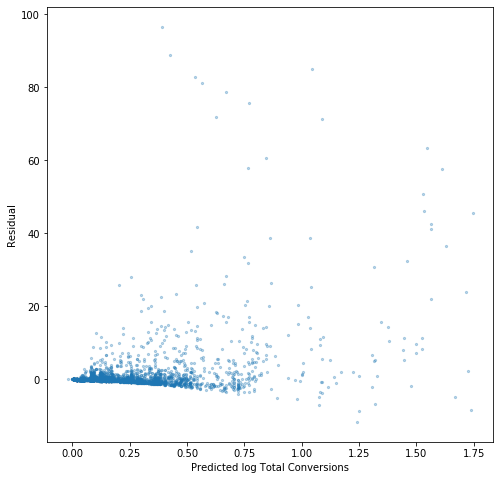

In [389]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.scatter(y_pred,resid,s=5, alpha=0.3)
plt.xlabel('Predicted log Total Conversions')
plt.ylabel ('Residual')
#plt.ylim(-2,2)
#plt.xlim(0,2)
plt.show()

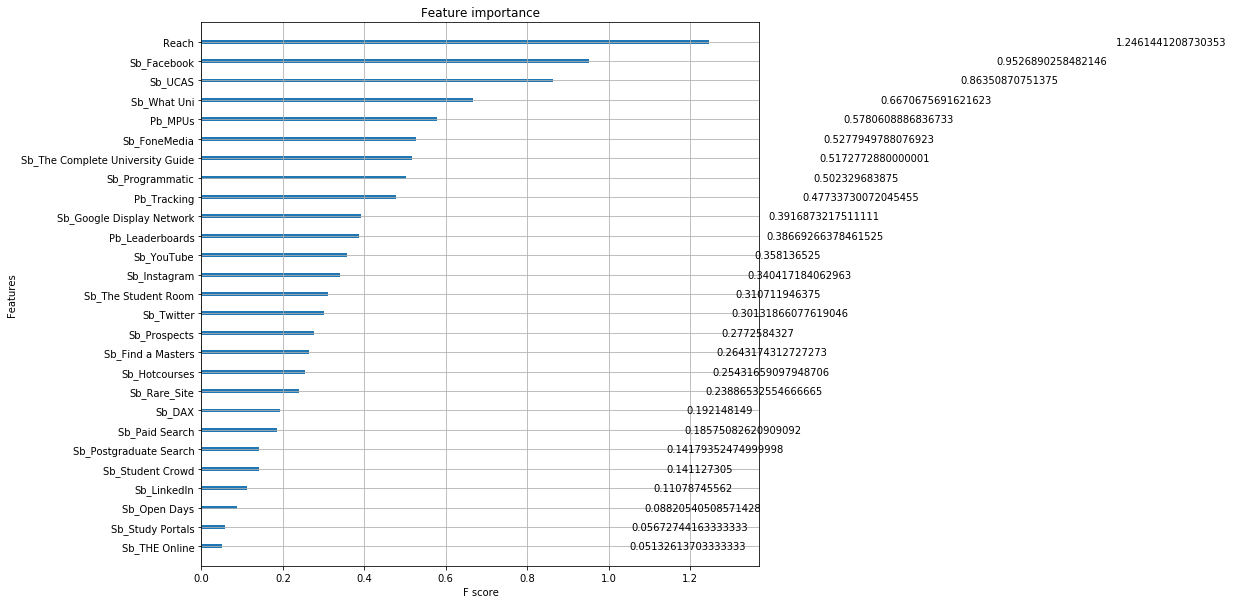

In [390]:
fig,ax=plt.subplots(figsize=(10,10),nrows=1,ncols=1)
xgb.plot_importance(reg.best_estimator_, ax=ax, importance_type='gain')

## Test metrics

In [391]:
y_pred = reg.best_estimator_.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test.values, y_pred))
r2 = r2_score(y_test.values, y_pred)

In [392]:
print(rmse)
print(r2)

0.24281466802982252
0.4299874143109236


## SHAP

In [393]:
import shap
explainer = shap.TreeExplainer(reg.best_estimator_)
shap_values = explainer.shap_values(X_train)

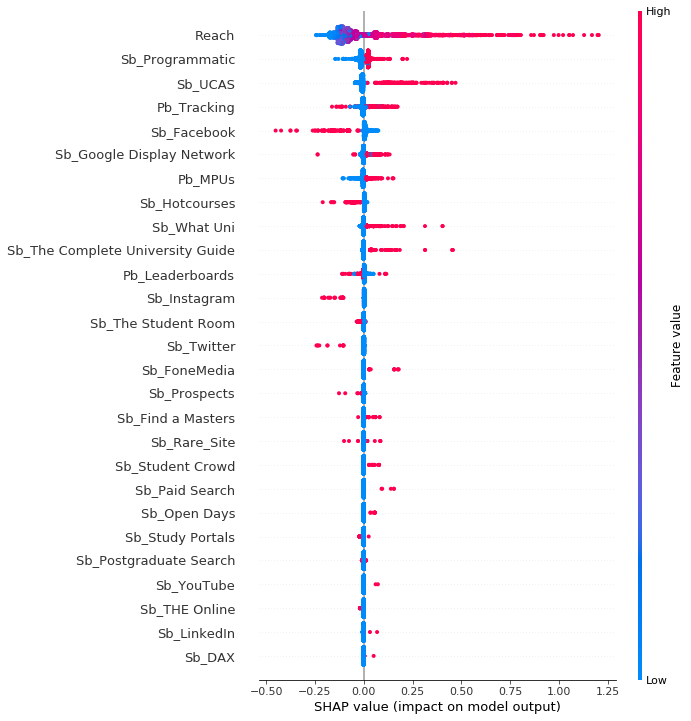

In [394]:
shap.summary_plot(shap_values, X_train, max_display=500)

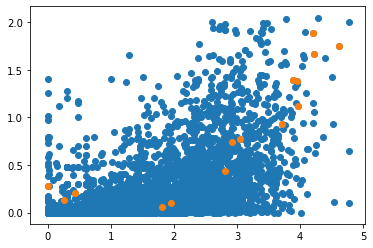

In [405]:
cond=merged_df['Site Bin']=='FoneMedia'
plt.scatter(merged_df['Reach'], merged_df['Total_Conversions'])
plt.scatter(merged_df[cond]['Reach'], merged_df[cond]['Total_Conversions'])

In [396]:
from scipy.stats import spearmanr, pearsonr
pearsonr(merged_df[cond]['Reach'], merged_df[cond]['Total_Conversions'])

(0.5313802204382648, 3.947841320147444e-20)